# Búsqueda en juegos competitivos

Adaptado de Russell and Norvig (2016), cap. 5.

### Problemas de confrontación

En clase discutimos la propuesta de Alan Turing frente a la pregunta "¿Pueden pensar las máquinas?", según la cual debemos considerar que un computador piensa si logra ganar el *juego de la imitación*. El objetivo de fondo de este juego es que el computador debe demostrar un comportamiento que los humanos juzguamos como inteligente. 

Existen formas más sencillas del juego de la imitiación, las cuales son  más convienientes para las máquinas que existían en la segunda mitad del siglo XX. Por ejemplo, un computador puede exhibir un comportamiento inteligente si tiene un buen desempeño en los juegos que los humanos juzgamos como desafiantes y que requieren (por lo menos una buena dosis) de inteligencia. Es por eso que el ajedrez computarizado fue tan relevante en los inicios de la IA.


### Objetivo

Estudiar algunas estrategias para la búsqueda de soluciones en juegos de dos jugadores. Estos escenarios son muy convenientes, toda vez que corresponden a entornos completamente observables, deterministas, discretos y conocidos. El desafío respecto al caso anterior es que ahora el entorno es dinámico, toda vez que este cambiará de acuerdo a las acciones del contrincante. 

### Secciones

Desarrollaremos la explicación de la siguiente manera:

1. Definición formal del problema de confrontación del triqui, y su implementación en python.
2. Algoritmo minmax para resolver el triqui, y su implementación en python.
3. Técnicas de búsqueda imperfecta basada en funciones de evaluación y cutting off.

### Juegos competitivos

La **definición formal** de un juego competitivo se hace con base en las siguientes características:

* **Estado inicial:** Situación del entorno desde el cual comienza el juego. En el caso del triqui, el estado inicial es el tablero vacío.

* **Jugador(s):** Define cuál jugador tiene el turno en el estado `s`, el cual puede ser `O` o `X`.

* **Posibles acciones(s):** Descripción de las posibles acciones del Jugador(`s`), dado un estado `s`. En este caso, poner o bien una `O` o una `X` en una casilla vacía.

* **Función de transiciones(s, a):** Descripción del entorno que resulta de la ejecución de la acción `a` por el `Jugador(s)` en el estado `s`. Junto con el estado inicial y las posibles acciones, la función de transiciones define el espacio de estados del juego.

* **Prueba de objetivo(s):** Permite determinar si el juego se termina cuando se obtiene el estado `s`. 

* **Función de utilidad(s):** Definida sólo cuando el juego se termina en el estado `s` y especifica la recompensa de cada jugador en `s`. En el caso del triqui, asumiremos que el ganador obtiene 1, el perdedor 0 y, en caso de empate, ambos jugadores obtienen $\frac{1}{2}$.

**Implementación en python**

Una posible implementación del juego del triqui en python es la siguiente.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import numpy as np
from random import choice
import copy

%matplotlib inline

In [2]:
class triqui:
    
    def estado_inicial(self):
        return np.matrix([[0]*3]*3)
    
    def pintar_estado(self, estado):
        # Dibuja el tablero correspondiente al estado
        # Input: estado, que es una 3-lista de 3-listas
        fig, axes = plt.subplots()

        # Dibujo el tablero
        step = 1./3
        offset = 0.001
        tangulos = []

        # Borde del tablero
        tangulos.append(patches.Rectangle((0,0),0.998,0.998,\
                                          facecolor='cornsilk',\
                                         edgecolor='black',\
                                         linewidth=2))

        # Creo las líneas del tablero
        for j in range(3):
            locacion = j * step
            # Crea linea horizontal en el rectangulo
            tangulos.append(patches.Rectangle(*[(0, locacion), 1, 0.008],\
                    facecolor='black'))
            # Crea linea vertical en el rectangulo
            tangulos.append(patches.Rectangle(*[(locacion, 0), 0.008, 1],\
                    facecolor='black'))

        for t in tangulos:
            axes.add_patch(t)

        # Cargando imagen de O
        arr_img_O = plt.imread("./imagenes/O.png", format='png')
        image_O = OffsetImage(arr_img_O, zoom=0.14)
        image_O.image.axes = axes

        # Cargando imagen de X
        arr_img_X = plt.imread("./imagenes/X.png", format='png')
        image_X = OffsetImage(arr_img_X, zoom=0.14)
        image_X.image.axes = axes

        offsetX = 0.15
        offsetY = 0.15

        # ASUMO QUE LAS O SE REPRESENTAN CON 1 EN LA MATRIZ
        # Y QUE LAS X SE REPRESENTAN CON 2
        for i in range(3):
            for j in range(3):
                if estado[j, i] == 1:
                    # print("O en (" + str(i) + ", " + str(j) + ")")
                    Y = 2 - j
                    X = i
                    # print("(" + str(X) + ", " + str(Y) + ")")
                    ab = AnnotationBbox(
                        image_O, 
                        [(X*step) + offsetX, (Y*step) + offsetY], 
                        frameon=False)
                    axes.add_artist(ab)
                if estado[j, i] == 2:
                    # print("X en (" + str(i) + ", " + str(j) + ")")
                    Y = 2 - j
                    X = i
                    # print("(" + str(X) + ", " + str(Y) + ")")
                    ab = AnnotationBbox(
                        image_X, 
                        [(X*step) + offsetX, (Y*step) + offsetY], 
                        frameon=False)
                    axes.add_artist(ab)
        
        axes.axis('off')
        return axes
    
    def jugador(self, estado):
        num_Os = np.count_nonzero(estado==1)
        num_Xs = np.count_nonzero(estado==2)
        # print("Cantidad O:", num_Os, " Cantidad X:", num_Xs)
        if num_Os < num_Xs:
            return 1
        else:
            return 2
    
    def acciones_aplicables(self, estado):
        # Devuelve una lista de parejas que representan las casillas vacías
        indices = []
        if np.count_nonzero(estado==0)>0:
            for x in range(3):
                for y in range(3):
                    if estado[y, x] == 0:
                        indices.append((x, y))
        
        return indices

    def transicion(self, estado, indice):
        # Devuelve el tablero incluyendo una O o X en el indice,
        # dependiendo del jugador que tiene el turno
        # Input: estado, que es una np.matrix(3x3)
        #        indice, de la forma (x,y)
        # Output: estado, que es una np.matrix(3x3)
        
        s = copy.deepcopy(estado)
        x = indice[0]
        y = indice[1]
        s[y, x] = self.jugador(estado)

        return s
    
    def test_objetivo(self, estado):
        # Devuelve True/False dependiendo si el juego se acabó
        # Input: estado, que es una np.matrix(3x3)
        # Output: True/False
        # print("Determinando si no hay casillas vacías...")
        if np.count_nonzero(estado==0)==0:
            return True
        else:
            # print("Buscando triqui horizontal...")
            for y in range(3):
                num_Os = np.count_nonzero(estado[y,:]==1)
                num_Xs = np.count_nonzero(estado[y,:]==2)
                # print("Cantidad O:", num_Os, " Cantidad X:", num_Xs)
                if (num_Os==3) or (num_Xs==3):
                    return True

            # print("Buscando triqui vertical...")
            for x in range(3):
                num_Os = np.count_nonzero(estado[:,x]==1)
                num_Xs = np.count_nonzero(estado[:,x]==2)
                # print("Cantidad O:", num_Os, " Cantidad X:", num_Xs)
                if (num_Os==3) or (num_Xs==3):
                    return True

            # print("Buscando triqui diagonal...")
            if (estado[0,0]==1) and (estado[1,1]==1) and (estado[2,2]==1):
                return True
            elif (estado[0,0]==2) and (estado[1,1]==2) and (estado[2,2]==2):
                return True

            # print("Buscando triqui transversal...")
            if (estado[2,0]==1) and (estado[1,1]==1) and (estado[0,2]==1):
                return True
            elif (estado[2,0]==2) and (estado[1,1]==2) and (estado[0,2]==2):
                return True
        
        return None

    def utilidad(self, estado):
        # Devuelve la utilidad del estado donde termina el juego
        # Input: estado, que es una np.matrix(3x3)
        # Output: utilidad, que es un valor -1, 0, 1
        ob = self.test_objetivo(estado)
        if ob:
            if np.count_nonzero(estado==0)==0: # No hay casillas vacías: empate
                return 0
            elif self.jugador(estado)==1: # Jugaron las X y ganaron
                return 1
            else: # Jugaron las O y ganaron
                return -1
        else:
            return None

**Ejercicio 1:** 

Implemente los métodos `acciones_aplicables`, `transicion`, `test_objetivo`, y `utilidad` para la clase `triqui`. Compruebe el funcionamiento de su implementación corriendo la siguiente celda:

Este es el tablero con una X en (1, 2)
Juego terminado?: None
Utilidad: None


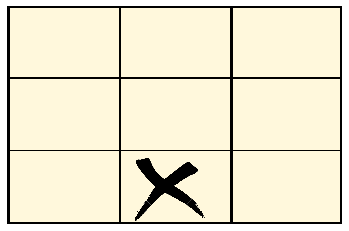

In [4]:
T = triqui()
s = T.estado_inicial()
a = choice(T.acciones_aplicables(s))
print("Este es el tablero con una X en", a)
s1 = T.transicion(s, a)
T.pintar_estado(s1)
print("Juego terminado?:", T.test_objetivo(s1))
print("Utilidad:", T.utilidad(s1))

### Árbol de confrontación

<img src="imagenes/arbol-minmax.png" width="500px">

### Algoritmo minmax

<img src="imagenes/ejemplo-minmax.png" width="400px">

<img src="imagenes/busqueda-minmax.png" width="400px">

**Ejercicio 2:**

Implemente la función `minimax_decision`.

**Respuesta:**

Una posible implementación es la siguiente:

In [84]:
def min_value(juego, estado):
    if juego.test_objetivo(estado):
        return juego.utilidad(estado)
    else:
        acciones = juego.acciones_aplicables(estado)
#        valores = [
#            (a, max_value(juego, juego.transicion(estado, a)))\
#            for a in acciones
#        ]
#        print("Busca minimo sobre:", valores)
        return min([
            max_value(juego, juego.transicion(estado, a))\
            for a in acciones
        ])

def max_value(juego, estado):
    if juego.test_objetivo(estado):
        return juego.utilidad(estado)
    else:
        acciones = juego.acciones_aplicables(estado)
 #       valores = [
 #           (a, min_value(juego, juego.transicion(estado, a)))\
 #           for a in acciones
 #       ]
 #       print("Busca maximo sobre:", valores)
        return max([
            min_value(juego, juego.transicion(estado, a))\
            for a in acciones
        ])

def minimax_decision(juego, estado):

    # Retorna la acción optima en el estado, para el jugador que lleva el turno
    acciones = juego.acciones_aplicables(estado)

    # Determina qué jugador tiene el turno
    if juego.jugador(estado)==2: # Juegan las X (MAX)        
#        valores = [
#            (a, min_value(juego, juego.transicion(estado, a)))\
#            for a in acciones
#        ]
#        print("minimax_decision X (MAX):", valores)
        indice = np.argmax([
            min_value(juego, juego.transicion(estado, a))\
            for a in acciones
        ])
    else: # Juegan las O (MIN)
 #       valores = [
 #           (a, min_value(juego, juego.transicion(estado, a)))\
#            for a in acciones
#        ]
#        print("minimax_decision O (MIN):", valores)
        indice = np.argmin([
            max_value(juego, juego.transicion(estado, a))\
            for a in acciones
        ])
        
    return acciones[indice]    

Compruebe su código con los siguientes tableros:

Computador juega en: (1, 2)


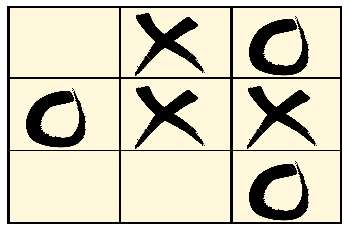

In [86]:
# Primer tablero de prueba
s1 = T.transicion(s, (1,1))
s1 = T.transicion(s1, (0,1))
s1 = T.transicion(s1, (2,1))
s1 = T.transicion(s1, (2,2))
s1 = T.transicion(s1, (1,0))
s1 = T.transicion(s1, (2,0))
T.pintar_estado(s1)
print("Computador juega en:", minimax_decision(T, s1)) # Debe ser (1, 2)

Computador juega en: (0, 0)


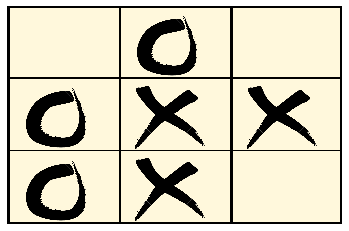

In [88]:
# Segundo tablero de prueba
s1 = T.transicion(s, (2,1))
s1 = T.transicion(s1, (0,1))
s1 = T.transicion(s1, (1,2))
s1 = T.transicion(s1, (1,0))
s1 = T.transicion(s1, (1,1))
s1 = T.transicion(s1, (0,2))
T.pintar_estado(s1)
print("Computador juega en:", minimax_decision(T, s1)) # Debe ser (0, 0)

Computador juega en: (1, 0)


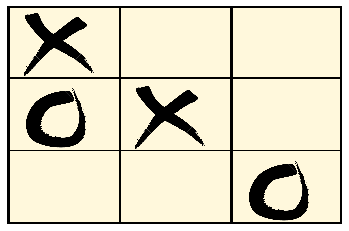

In [90]:
# Tercer tablero de prueba
s1 = T.transicion(s, (1,1))
s1 = T.transicion(s1, (0,1))
s1 = T.transicion(s1, (0,0))
s1 = T.transicion(s1, (2,2))
T.pintar_estado(s1)
print("Computador juega en:", minimax_decision(T, s1)) # Debe ser (1, 0) o (2, 0)

Computador juega en: (2, 0)


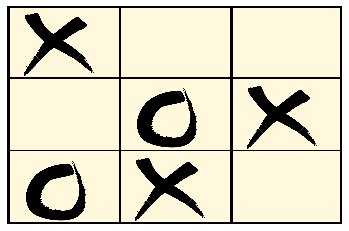

In [96]:
# Cuarto tablero de prueba
s1 = T.transicion(s, (2,1))
s1 = T.transicion(s1, (1,1))
s1 = T.transicion(s1, (1,2))
s1 = T.transicion(s1, (0,2))
s1 = T.transicion(s1, (0,0))
T.pintar_estado(s1)
print("Computador juega en:", minimax_decision(T, s1)) # Debe ser (2, 0)

### Funciones de evaluación

### Cutting off search